# Kaggle Leaf Classification Challenge


In [1]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

In [2]:
## If you are working on Colab, data_utils can be downloaded using the command below (uncomment line below)
# ! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch/6_Mini_Project/leaf-classification
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you are running this notebook on Google Colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from Kaggle to Colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. Upload the data to Google Drive
2. Mount the Google Drive (see cell below)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [5]:
# !ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [6]:
# path = 'drive/My Drive/leaf-classification/'
path = 'leaf-classification/'  # if you're folder structure is as defined above and you want to run locally

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [7]:
image_paths = glob.glob(path+'images/*.jpg')
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv(path + 'train.csv')
train_images = [path+'images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(path + 'test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [8]:
# Number of samples in the training and test datasets
print(f"Training samples: {train.shape[0]}")
print(f"Test samples: {test.shape[0]}")

# Check if the columns in train and test datasets are the same
train_columns = train.columns
test_columns = test.columns

column_difference = train_columns.symmetric_difference(test_columns)
print(f"Difference in columns: {column_difference}")

# Number of samples per species
species_counts = train['species'].value_counts()
print("\nNumber of samples per species:")
print(species_counts)

Training samples: 990
Test samples: 594
Difference in columns: Index(['species'], dtype='object')

Number of samples per species:
species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64


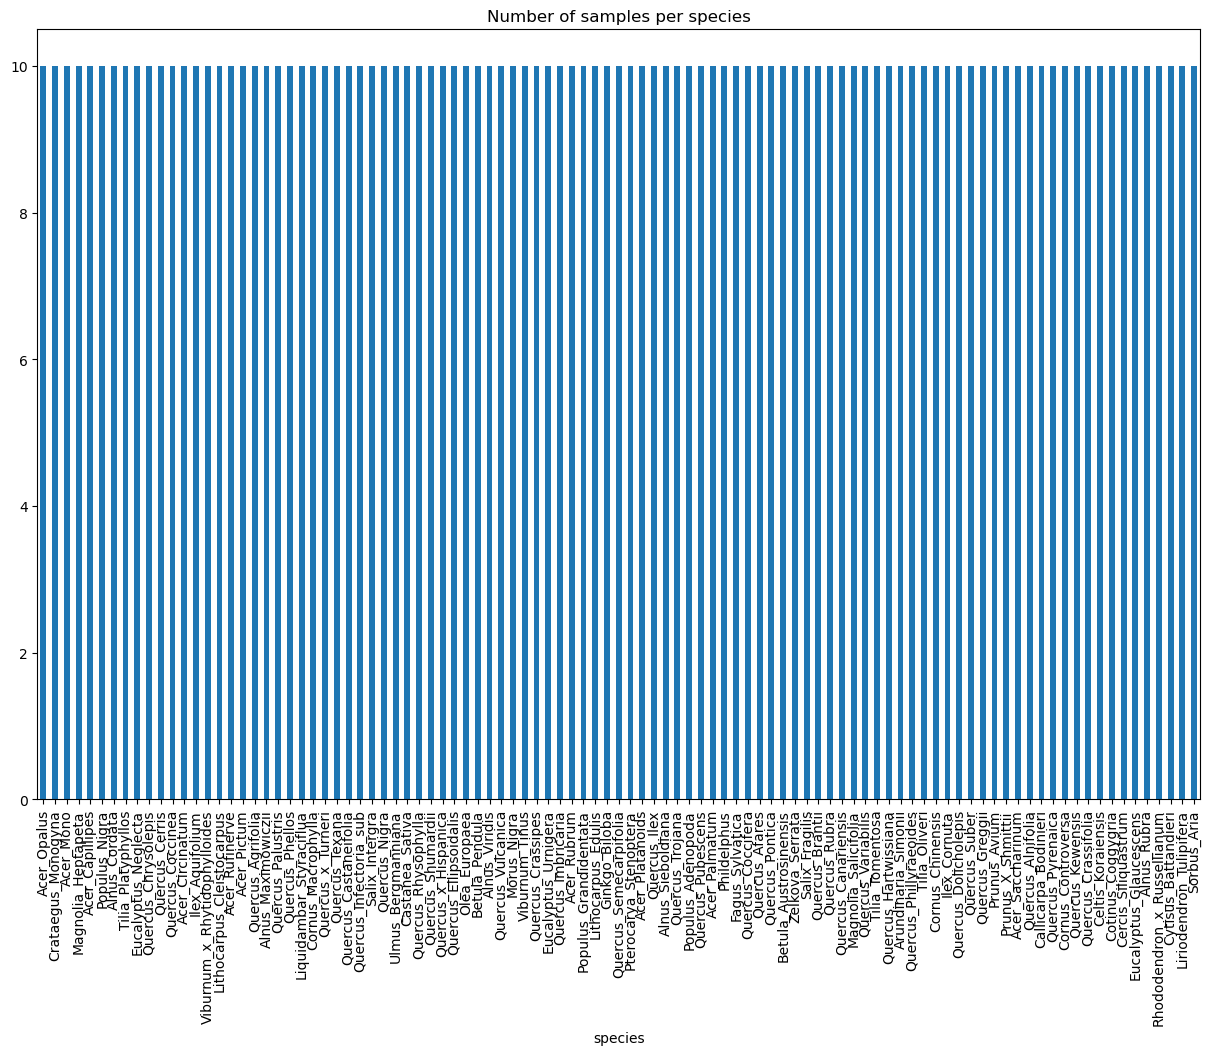

In [9]:
# plotting the distribution of species
species_counts.plot(kind='bar', figsize=(15, 10))
plt.title("Number of samples per species")
plt.show()

 * **Answer:**

 > The dataset consists of 990 training samples and 594 test samples. Each sample corresponds to a unique leaf image. The training data includes both features and the target labels (species), whereas the test data does not include species labels. The difference between the training and test datasets lies in the presence of the targets column which is the species. The training dataset is balanced, with 99 different species, each represented by exactly 10 samples. This balance ensures that the model has an equal representation of all species during training, reducing the risk of bias toward any specific class.

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

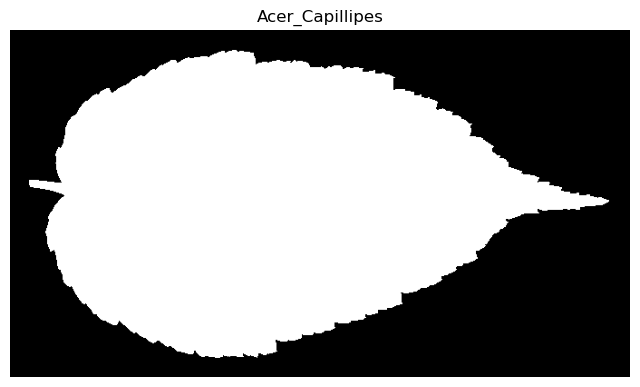

In [10]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(path + 'images\{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

In [11]:
image_paths = [os.path.normpath(p) for p in glob.glob(path + 'images\*.jpg')]
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

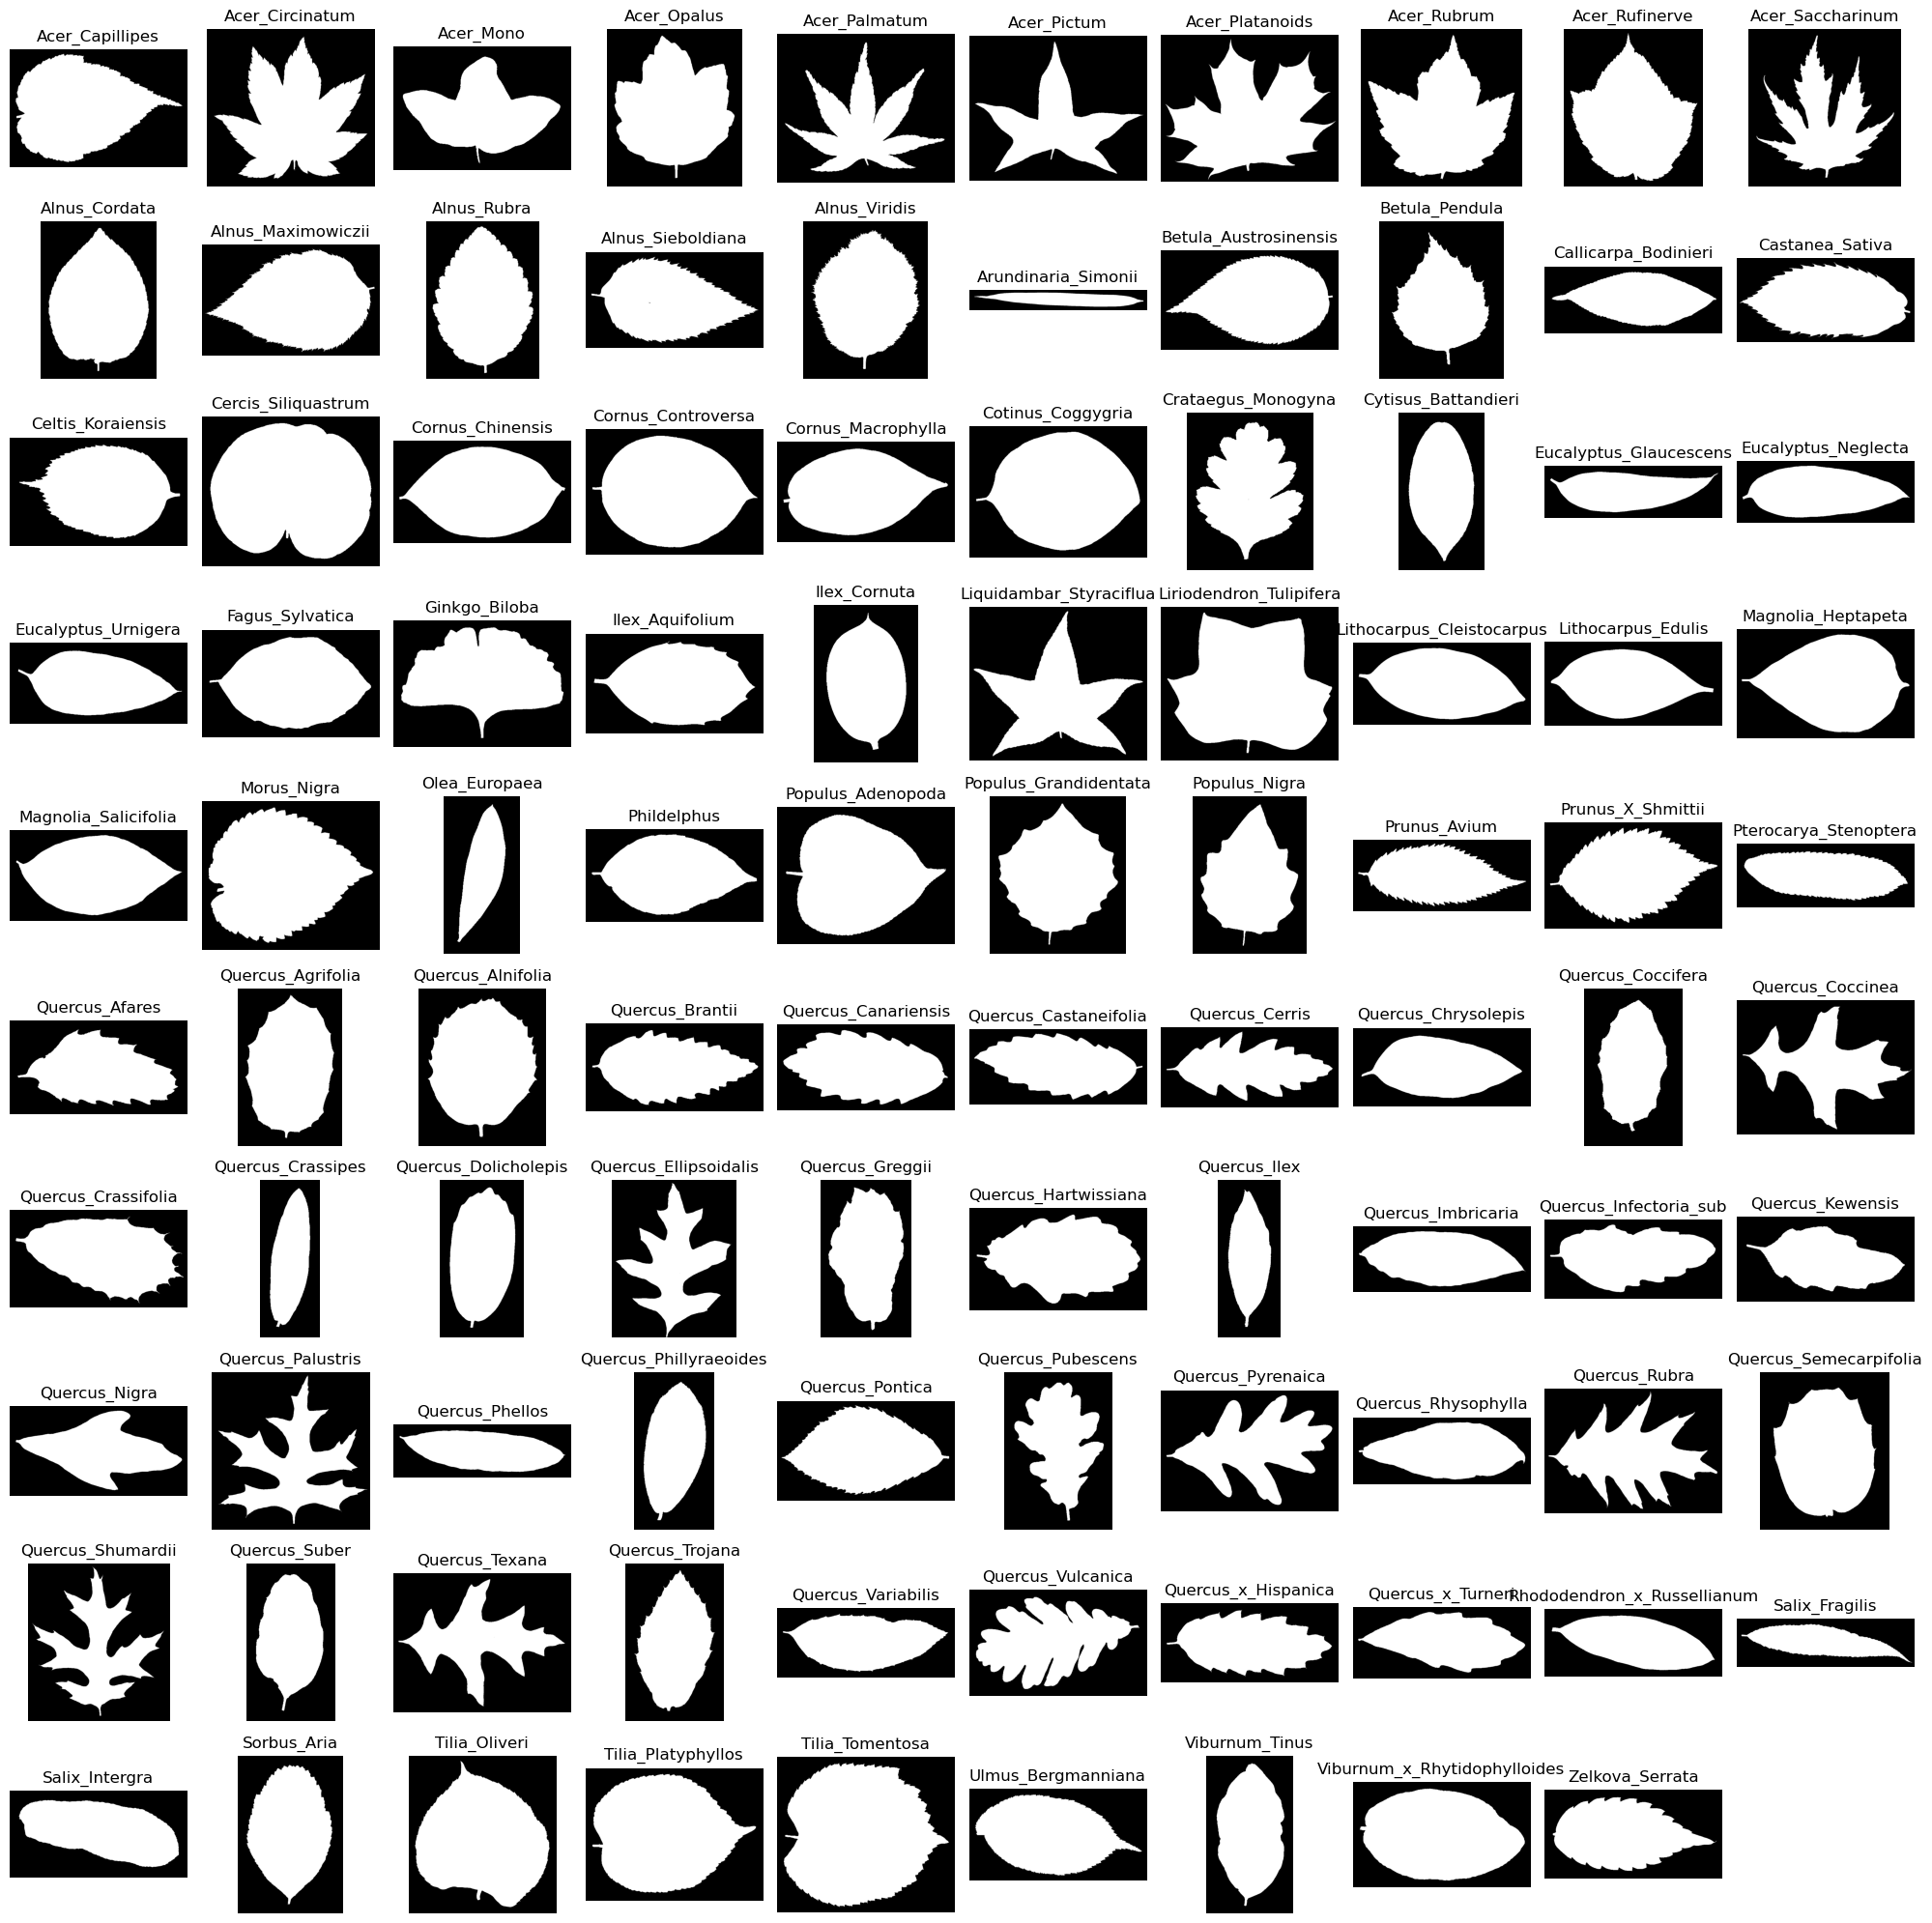

In [12]:
plt.figure(figsize=(20, 20))  
for i, s in enumerate(species):
    image_id = species_examples[i]
    image_path = os.path.normpath(path + 'images\{}.jpg'.format(image_id))
    if image_path in image_paths:
        plt.subplot(10, 10, i + 1) 
        image = imread(image_path, as_gray=True)
        plt.imshow(image, cmap='gray')
        plt.title(s)
        plt.axis('off')  

plt.tight_layout()
plt.show()

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


In [13]:
# shape of the images
image = imread(image_paths[0], as_gray=True)
print("Shape of the images:\t", image.shape)

Shape of the images:	 (467, 526)


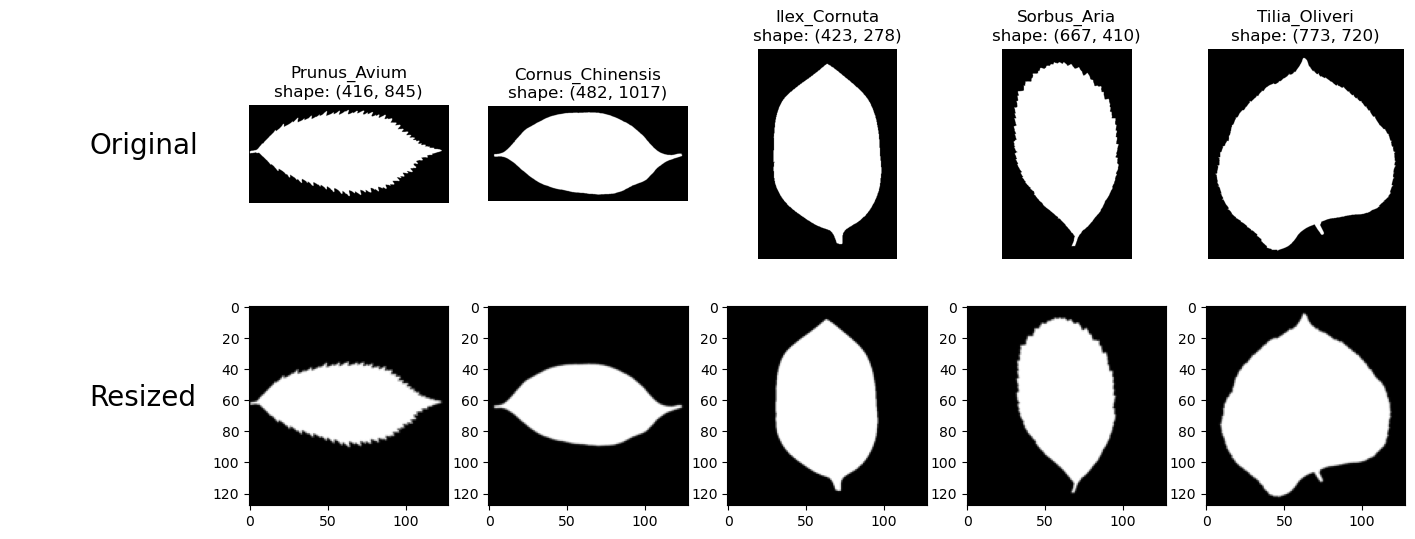

In [14]:
## Image pre-processing
image_size = (128, 128)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

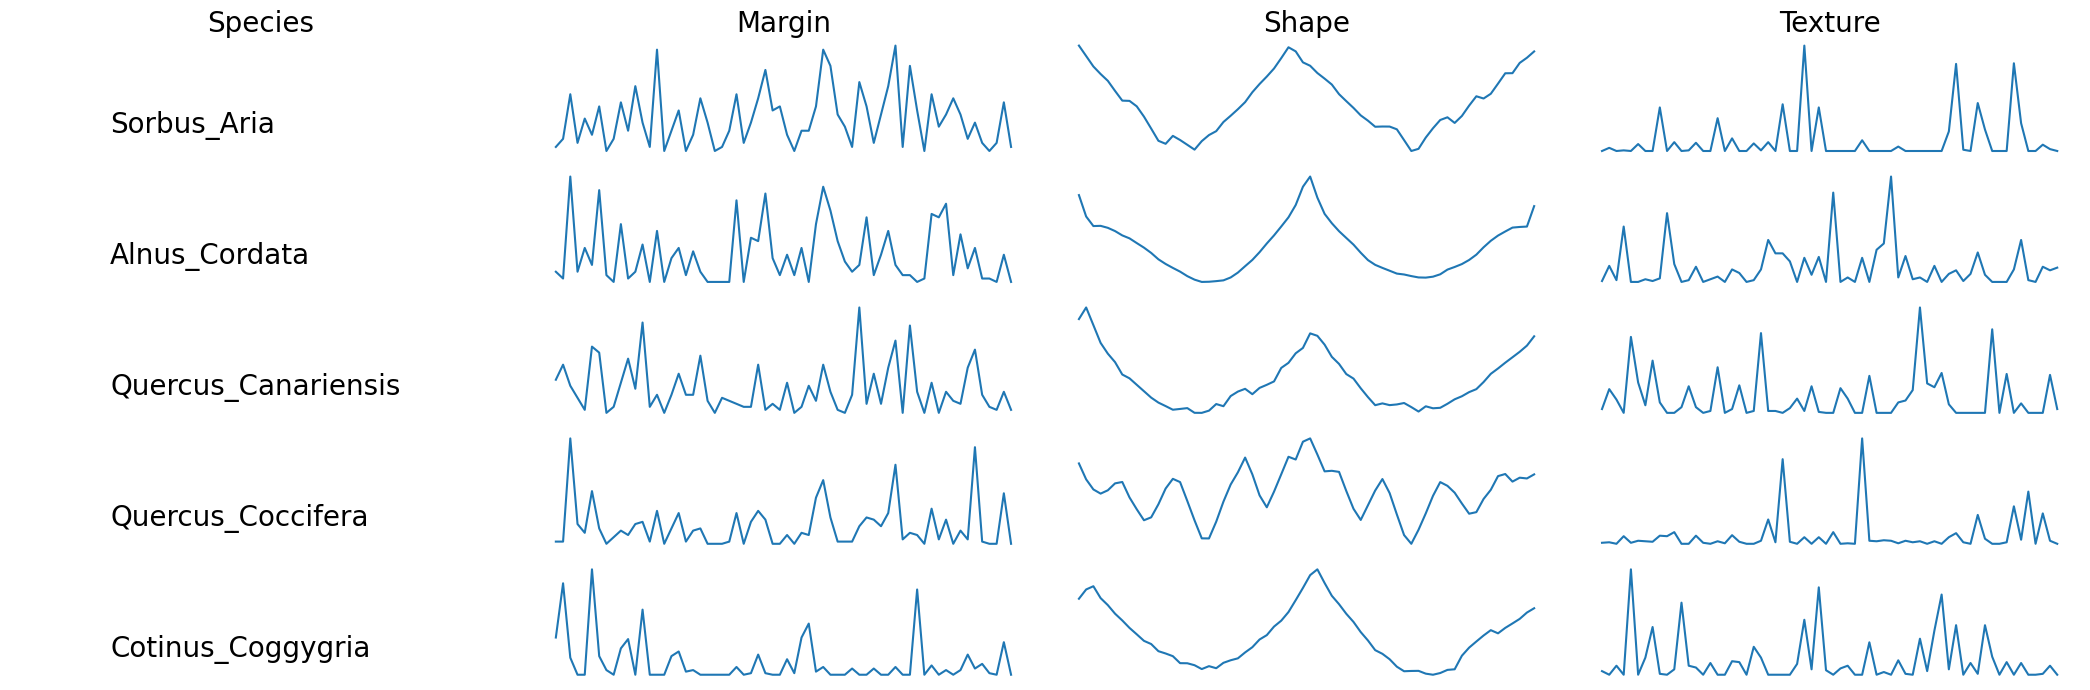

In [15]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**

 > For classifying leaves, **Convolutional Neural Networks (CNNs)** should be used for image data due to their ability to extract spatial features, while **Feedforward Neural Networks (FFNNs)** are suitable for numerical features like margin, shape, and texture as they can model relationships between structured data. A hybrid model (CNN+feedforward Neural Network) approach combining both can enhance overall classification accuracy. A CNN to extract features from images and FFNNs to process margin, shape, and texture features. The outputs from these networks can be concatenated and passed through additional layers to make a final classification.
 

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

In [16]:
# Extract feature names
feature_names = train.columns[2:]  # Skip 'id' and 'species'

# Count features for each type
NUM_FEATURES = {
    'margin': len([col for col in feature_names if col.startswith('margin')]),
    'shape': len([col for col in feature_names if col.startswith('shape')]),
    'texture': len([col for col in feature_names if col.startswith('texture')])
}

# Print the results
print("Number of Margin Features:", NUM_FEATURES['margin'])
print("Number of Shape Features:", NUM_FEATURES['shape'])
print("Number of Texture Features:", NUM_FEATURES['texture'])


Number of Margin Features: 64
Number of Shape Features: 64
Number of Texture Features: 64


## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [17]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (128,128,1)    # <-- Your answer here
NUM_CLASSES = 99   # <-- Your answer here 

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64# <-- Your answer here

In [18]:
path= 'leaf-classification/'
# Paths to data
TRAIN_PATH = path + "train.csv" 
TEST_PATH = path + "test.csv" 
IMAGE_PATHS = glob.glob(path + "images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 128, 128, 1)0.281170
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 128, 128, 1)	0.281457
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time.

In [19]:
# import pickle

# # Dump the data into a pickle file
# with open(path + '/data.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [20]:
# # Load the data from a pickle file
# with open(path + '/data.pickle', 'rb') as f:
#     data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:**

> The batch size directly impacts memory usage, training speed, and the accuracy of gradient estimates. Larger batches require more memory because more data is processed at once, which can lead to memory issues, especially on GPUs with limited capacity. However, larger batches also improve computational efficiency and can speed up training by processing more data per step, though each step may take longer. Smaller batches, on the other hand, use less memory and result in faster individual steps, but more steps are needed to cover the same amount of data, potentially slowing down overall training. In terms of gradient estimates, larger batches provide smoother and more accurate gradients since they average over more data points, leading to stable convergence. In contrast, smaller batches produce noisier gradients, which can cause more volatile training but may also help the model escape local minima and improve generalization. For the classification task the ideal batch size of 32 was chosen. 

In [21]:
batch_size = 32
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (32, 128, 128, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

VALID
	images, (32, 128, 128, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

TEST
	images, (32, 128, 128, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ids, 32


# Build the model

In [22]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [23]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [25]:
height, width, channels = IMAGE_SHAPE

conv_out_channels = 32  # <-- Example number of filters in your convolutional layer
kernel_size = (3, 3)    # <-- Example kernel size
conv_stride = 1         # <-- Example stride
conv_pad = 1            # <-- Example padding

conv_out_channels_2 = 64  
conv_out_channels_3 = 128 
kernel_size_2 = (3, 3)     
kernel_size_3 = (3, 3)     
NUM_CLASSES = 99         

# Function to calculate output size after convolution
def conv_output_size(input_size, kernel_size, padding, stride):
    return (input_size + 2 * padding - kernel_size) // stride + 1

# Calculate output dimensions after conv layers
height_after_conv_1 = conv_output_size(height, kernel_size[0], conv_pad, conv_stride)
width_after_conv_1 = conv_output_size(width, kernel_size[1], conv_pad, conv_stride)

height_after_conv_2 = conv_output_size(height_after_conv_1, kernel_size[0], conv_pad, conv_stride)
width_after_conv_2 = conv_output_size(width_after_conv_1, kernel_size[1], conv_pad, conv_stride)

height_after_conv_3 = conv_output_size(height_after_conv_2, kernel_size[0], conv_pad, conv_stride)
width_after_conv_3 = conv_output_size(width_after_conv_2, kernel_size[1], conv_pad, conv_stride)

# Flatten size after the last conv layer
flattened_size = conv_out_channels_3 * height_after_conv_3 * width_after_conv_3

batch_size = 32  
x_margin = torch.rand(batch_size, 64)  
x_texture = torch.rand(batch_size, 64)  

# Update features_cat_size according to the size of x_margin and x_texture
features_cat_size = flattened_size + x_margin.shape[1] + x_texture.shape[1]  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                 out_channels=conv_out_channels,
                                 kernel_size=kernel_size,
                                 stride=conv_stride,
                                 padding=conv_pad)
        
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                 out_channels=conv_out_channels_2,
                                 kernel_size=kernel_size_2,
                                 stride=conv_stride,
                                 padding=conv_pad)
        
        self.conv_3 = nn.Conv2d(in_channels=conv_out_channels_2,
                                 out_channels=conv_out_channels_3,
                                 kernel_size=kernel_size_3,
                                 stride=conv_stride,
                                 padding=conv_pad)
        
        # self.rnn_1 = nn.GRU(input_size=128, hidden_size=64, num_layers=1, batch_first=True)  # GRU layer

        # Fully connected output layer
        self.l_out = nn.Linear(in_features=features_cat_size,
                               out_features=NUM_CLASSES,
                               bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        #Convolutional layers 
        x_img = x_img.view(-1, channels, height, width)  
        
        # 1st conv layer + relu 
        features_img = self.conv_1(x_img)                
        features_img = torch.relu(features_img)          
        
        # 2nd conv layer + relu 
        features_img = self.conv_2(features_img)         
        features_img = torch.relu(features_img)          
        
        # 3rd conv layer + relu
        features_img = self.conv_3(features_img)         
        features_img = torch.relu(features_img)          
       
        # Flatten features for fully connected layer
        features_img = features_img.view(features_img.size(0), -1)  
        
        # Append features to the list features
        features.append(features_img)
        
        #Concatenate other features 
        x = torch.cat((x_margin, x_texture), dim=1)  
        features_vector = x
        features.append(features_vector)

        features_final = torch.cat(features, dim=1)

        # ## Use concatenated leaf features for RNN ##
        # - Change dimensions to fit GRU (assuming x_shape is [batch_size, seq_len, features])
        # x_shape = x_shape.view(-1, 1, 64)  # Reshape for GRU input
        # _, features_rnn = self.rnn_1(x_shape)  # Apply GRU
        # features_rnn = features_rnn[-1]  # Take the last hidden state
        
        # Append features to the list "features"
        # features.append(features_rnn)
        
        output = self.l_out(features_final)
        out['out'] = output  
        return out

net = Net()
use_cuda = torch.cuda.is_available()  
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l_out): Linear(in_features=2097280, out_features=99, bias=False)
)


# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [26]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss() # <-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [27]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 0.0428, -0.0284,  0.0391,  ..., -0.0330,  0.0086,  0.0398],
        [ 0.0145,  0.0147,  0.0424,  ..., -0.0542,  0.0196, -0.0022],
        [ 0.0037,  0.0348,  0.0511,  ..., -0.0726,  0.0143, -0.0446],
        ...,
        [ 0.0185, -0.0304,  0.0619,  ..., -0.0304,  0.0034,  0.0058],
        [-0.0077, -0.0137,  0.0444,  ..., -0.0227, -0.0208, -0.0289],
        [-0.0281, -0.0267,  0.0836,  ..., -0.0267,  0.0015,  0.0016]],
       device='cuda:0', grad_fn=<MmBackward0>)

# Train

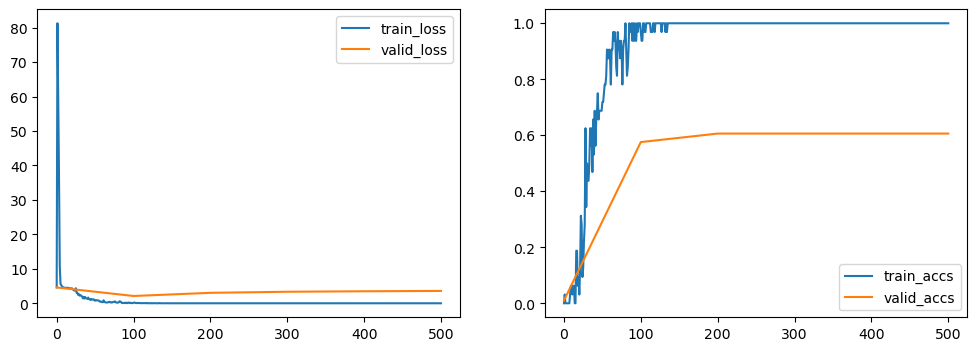

In [28]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 500
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
        #print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
        #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

In [29]:
# print the train and validation accuraacy
print("Train accuracy: ", train_accs[-1])
print("Validation accuracy: ", valid_accs[-1])


Train accuracy:  1.0
Validation accuracy:  0.6060606


## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**
> **Final Architecture:**
The final neural network architecture consists of three convolutional layers, each followed by ReLU activation functions to introduce non-linearity. These layers progressively increase in depth, starting with 32 filters, followed by 64 and 128 filters. The convolutional layers are designed to extract spatial features from the image input. The output from the third convolutional layer is flattened, and additional features (margin and texture) are concatenated with the image features. A fully connected linear layer then produces the logits for the 99 species classes, without softmax, since we use cross-entropy loss for training, which includes the softmax internally.
>
> **Training Parameters:**
Batch Size: 32
Learning Rate: 0.001
Epochs: 500
Loss Function: CrossEntropyLoss
Optimizer: Adam with a learning rate of 0.001, and L2 regularization applied using weight_decay. The batch size of 32 was chosen as it provides a good balance between training speed, memory efficiency, and gradient estimation accuracy. Cross-entropy loss was used due to its suitability for multi-class classification tasks.
>
> **Final Results:**
>- Kaggle Score: 3.01262
>- Validation Accuracy: 0.6060606 
>
>The final architecture produced a Kaggle score of 3.01262, indicating moderate performance. Although the network captured some important features, the validation accuracy remained low at around 0.6, suggesting that the model struggles with generalizing to unseen data. This may be due to the limited complexity of the architecture as increasing the number of layers made my system GPU to crash but they might've captured higher-level interactions between features.
>
> **Insights:**
>- The convolutional layers successfully captured the spatial structure of the input images, and the combination of image features with margin and texture data improved the overall accuracy compared to image-only models.
>
>- The model's performance plateaued, and increasing the complexity of the architecture (e.g., adding more convolutional or linear layers) did not lead to significant improvements. The chosen learning rate and optimizer seemed to work well for convergence. 
>
>- Adam accelerates training with adaptive learning rates for faster convergence, while SGD provides stable updates and better generalization by exploring the parameter space and reducing overfitting. 
>
>- Since the data was less the model was evidently overfitting because of which the batch normalisation and dropout weren't helpful as they are pretty helpful when it comes to making sure the batch data is uniform and that the model doesn't rely on certain weights. 
>
>- I tried increasing the depth of the model but my system GPU couldn't handle additional layers. So, I stopped with 3 layers and 500 epochs. 



# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [30]:
# GET PREDICTIONS
# Containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()

# Run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    
    # Get the raw logits from the output
    y_out_logits = output['out'].data.cpu()  
    
    # Apply softmax to get probabilities
    y_out_probs = softmax(y_out_logits, dim=1)  

    ids_test += batch_test['ids']
    if num != len(y_out_probs):
        # In case of the last batch, num will be less than batch_size
        y_out_probs = y_out_probs[:num]
    preds_test.append(y_out_probs)
preds_test = torch.cat(preds_test, dim=0).numpy()  
assert len(ids_test) == len(preds_test)


## Make submission file

In [31]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.309264e-15,1.674668e-10,1.223416e-17,2.010099e-06,2.727706e-11,9.564844e-14,3.424394e-17,2.480908e-09,5.049973e-09,...,4.349800e-15,1.031533e-16,2.661181e-06,2.325329e-11,6.739786e-12,1.115012e-11,5.082209e-16,1.834615e-13,3.541558e-16,1.214091e-15
1,7,3.678992e-16,4.419761e-20,1.532662e-11,2.184934e-16,3.700532e-21,4.658512e-16,3.814950e-13,3.034593e-15,2.475343e-17,...,1.845124e-20,9.409189e-14,2.435789e-22,2.261895e-18,1.223143e-12,4.798285e-19,7.014135e-12,1.020936e-19,3.473964e-16,6.883590e-08
2,9,2.712745e-14,4.170569e-07,1.072775e-16,3.893213e-08,5.218882e-09,3.314523e-12,9.956809e-01,1.901206e-06,5.898686e-12,...,8.051102e-15,2.758743e-16,1.628484e-15,4.416756e-09,3.943510e-08,2.809619e-06,1.598154e-17,8.055115e-18,2.136858e-14,2.098780e-17
3,12,5.349239e-15,3.541862e-18,1.501298e-12,1.634703e-14,2.792371e-16,5.724487e-15,3.508229e-12,2.519891e-14,5.933620e-14,...,5.617851e-17,4.249598e-09,5.390193e-20,6.381883e-17,9.559068e-15,2.102157e-15,1.128519e-12,1.086440e-16,9.717006e-16,3.360558e-14
4,13,8.904455e-17,6.807734e-05,9.925668e-20,8.136158e-11,1.851468e-11,3.219025e-13,2.877880e-10,3.251682e-13,6.543215e-14,...,9.793486e-16,2.302099e-18,7.201728e-04,1.974959e-09,5.971523e-08,2.366406e-08,2.351968e-18,1.104170e-14,3.642089e-19,7.366890e-17


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 